In [18]:
1

1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
NIR_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_NIR_R4300.h5"
sys.path.insert(0, PROJECT_PATH)

# Red Arm

In [110]:
from lv.base.basePCA import PCA

In [111]:
p=PCA()
p.W = p.Ws["RedM"]

In [9]:
PATH = f"/scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_5000/spectra.h5"

with h5py.File(PATH, 'r') as f:
#     flux0 = f['flux'][()]
    wave0 = f['wave'][()]
#     para0 = f['para'][()]

In [10]:
idx0,idx1 = np.digitize([7100,8850],wave0)

In [11]:
waveH = wave0[idx0:idx1]

In [12]:
waveH.shape

(2204,)

In [ ]:
wave

In [113]:
flux0.shape

(116614, 2204)

In [114]:
p.prepare_data(flux0, wave0, para0)

# M flux: 7689, wave None: (2204,) 
# W flux: 6480, wave None: (2204,) 
# C flux: 3780, wave None: (2204,) 
# B flux: 3300, wave None: (2204,) 
# R flux: 2100, wave None: (2204,) 
# G flux: 9972, wave None: (2204,) 


In [1]:
fluxs,paras,lbls = p.stack_data()

NameError: name 'p' is not defined

In [13]:
R="BHB"

In [15]:
RBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R}/rbf_RMLL_R500_1k.h5"
with h5py.File(RBF_PATH, 'r') as f:
    flux0 = f['normflux'][()]
    pval0 = f['pval'][()]
    wave0 = f['wave'][()]

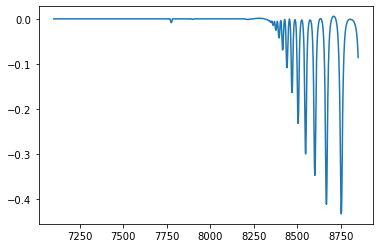

In [17]:
plt.plot(wave0, flux0[0])

# Load from RBF

In [6]:
def collect_flux(nSample=10000, Rs=None):
    fluxs=[]
    pvals=[]
    lbls =[]
    if Rs is None: Rs = ["M31G", "MWW", "MWC", "BHB", "RHB"]
    for ii, R in enumerate(Rs):
        RBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R}/rbf_RedM_R500_100k.h5"
        with h5py.File(RBF_PATH, 'r') as f:
            flux0 = f['normflux'][()]
            pval0 = f['pval'][()]
            wave0 = f['wave'][()]
        fluxs.append(flux0[:nSample])
        pvals.append(pval0[:nSample])
        lbls.append(np.zeros(nSample) + ii)
    fluxs = np.vstack(fluxs)
    pvals = np.vstack(pvals)
    lbls = np.hstack(lbls)
    lbln = [Rs[int(lbls[i])] for i in range(len(lbls))]    
    print(fluxs.shape, pvals.shape, lbls.shape)
    return fluxs, pvals, lbls, lbln, wave0

In [7]:
fluxs, pvals, lbls, lbln, wave0 = collect_flux()

(50000, 2204) (50000, 5) (50000,)


In [8]:
from lv.base.dataloader_c import DataLoader

In [9]:
ds = DataLoader()

In [10]:
ds.prepare_data_custom("RedM", fluxs, wave0, pvals, lbl=lbln)

(50000, 2204) (2204,) (50000, 5)


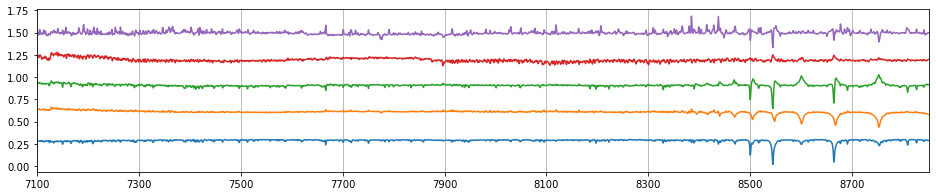

In [11]:
ds.init_pcp()

In [12]:
k,q,prom = 10, 0.75, 0.02
# k,q,prom = 5, 0.7,0.02
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

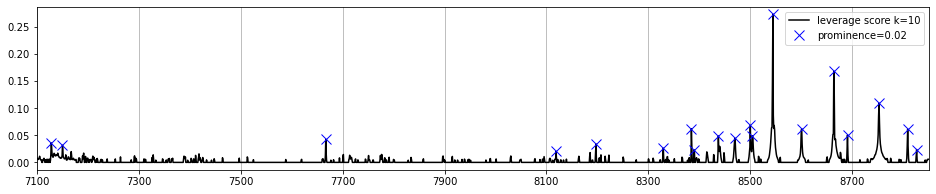

In [13]:
ds.plot_peaks(nvv, peaks, k, prom)

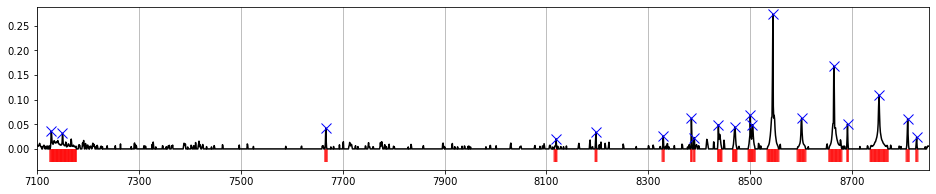

In [14]:
ds.plot_mask_from_peaks(peaks, prop, nvv)

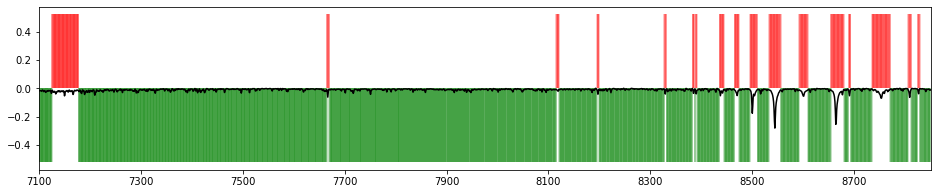

In [15]:
ds.plot_MN_mask(0)

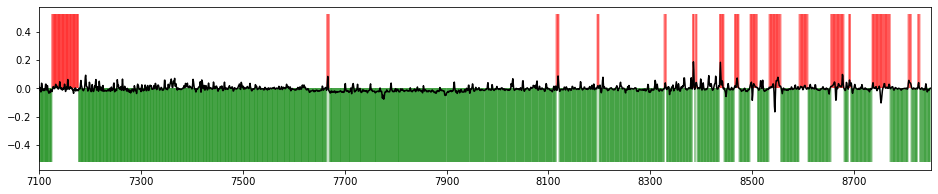

In [16]:
ds.plot_MN_mask(4)

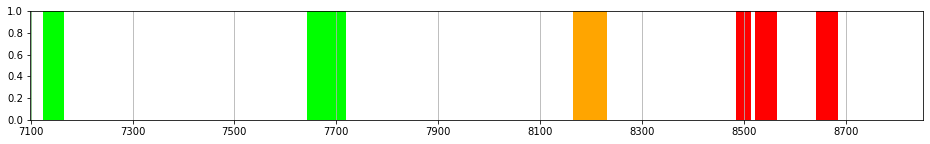

In [17]:
ds.plot_lick()

In [18]:
ds.get_MN(ds.nmask, top=5)

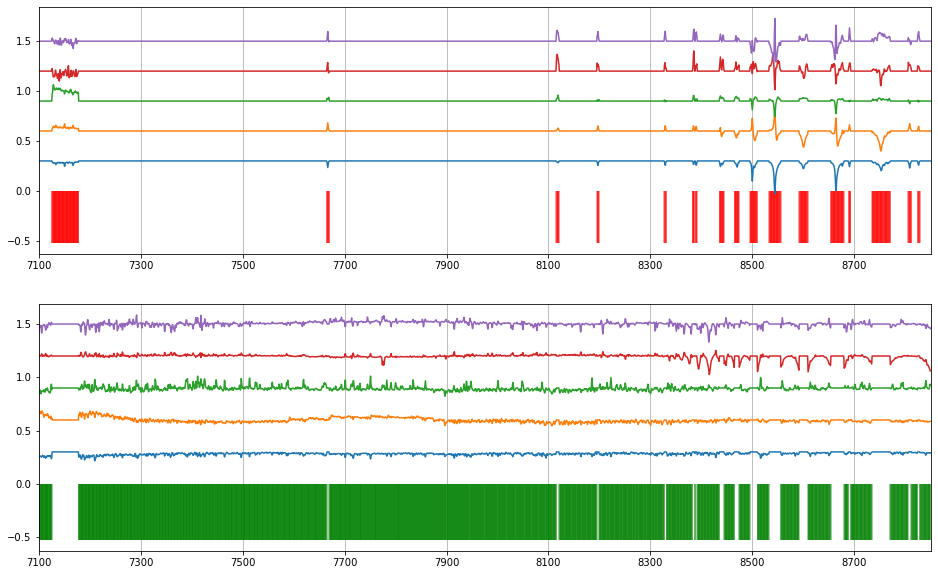

In [19]:
ds.plot_MN(step=0.3)

In [20]:
mu = 1.0 / ds.Mw[2]
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-5, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.01, lambda 0.0045, norm 272804.3


L(47, 279), S(30, 279)


(47, 2204)


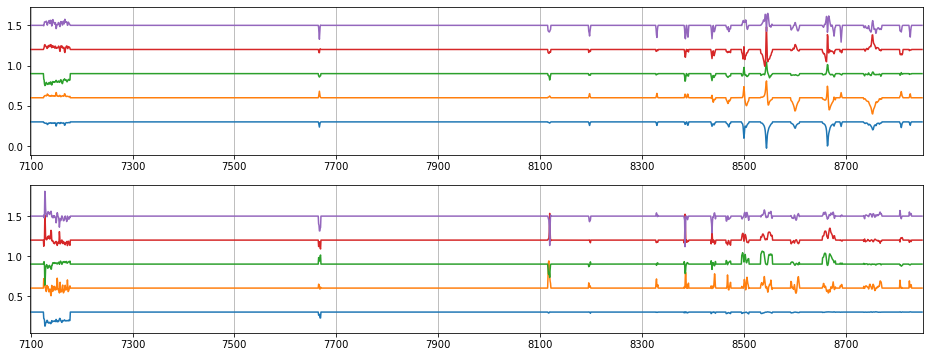

In [21]:
nMLv, nMSv =ds.eval_pcp(MLv, MSv)

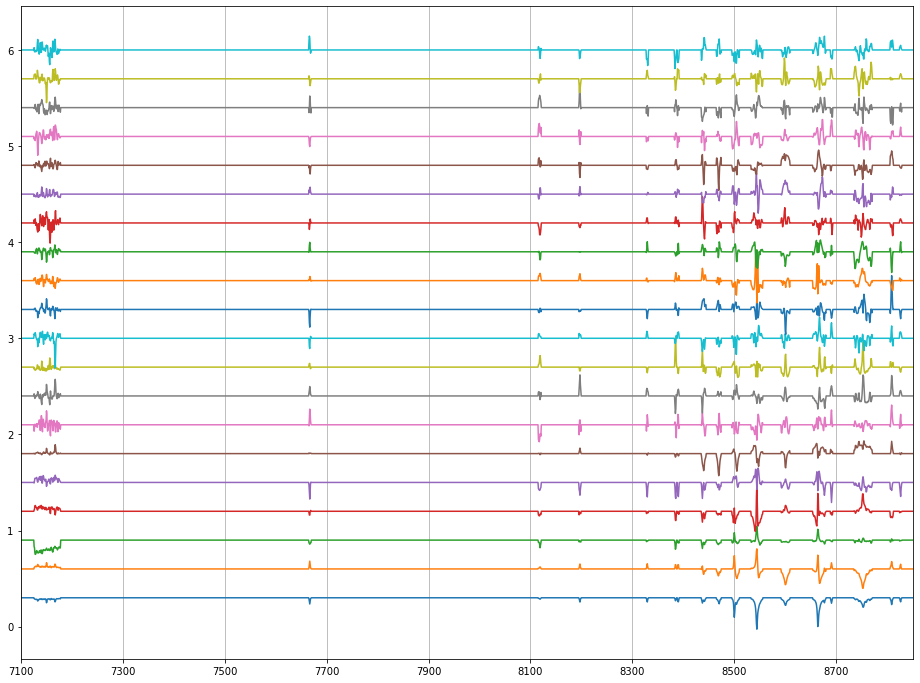

In [22]:
ds.plot_V(nMLv, top=20)

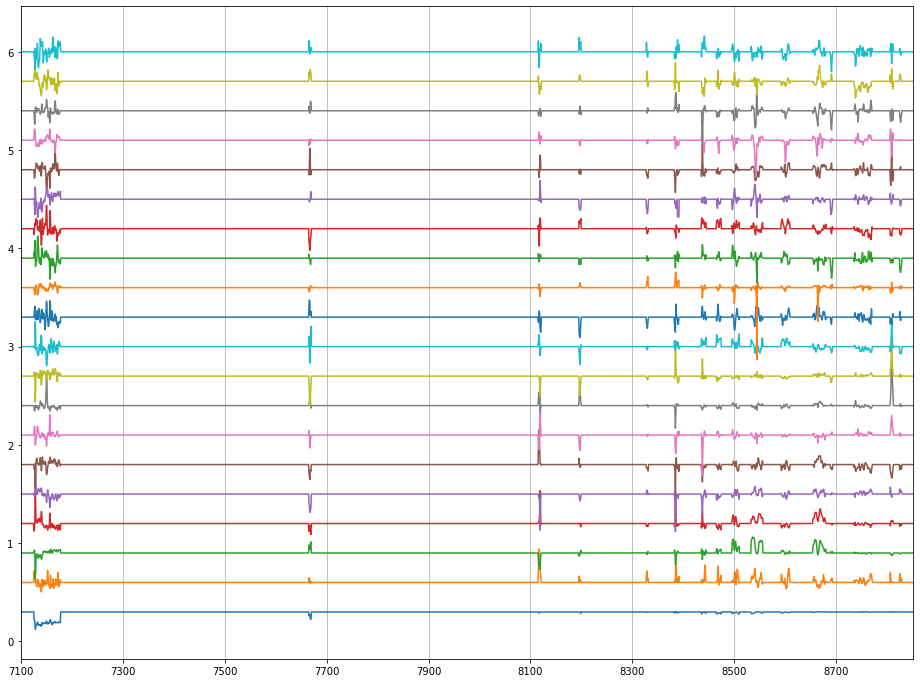

In [23]:
ds.plot_V(nMSv, top=20)

In [24]:
mu = 1.0 / ds.Nw[2]
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=mu, lam=None, norm=None, maxiter=100)

mu 0.01, lambda 0.0045, norm 129258.7


L(40, 1925), S(30, 1925)


(40, 2204)


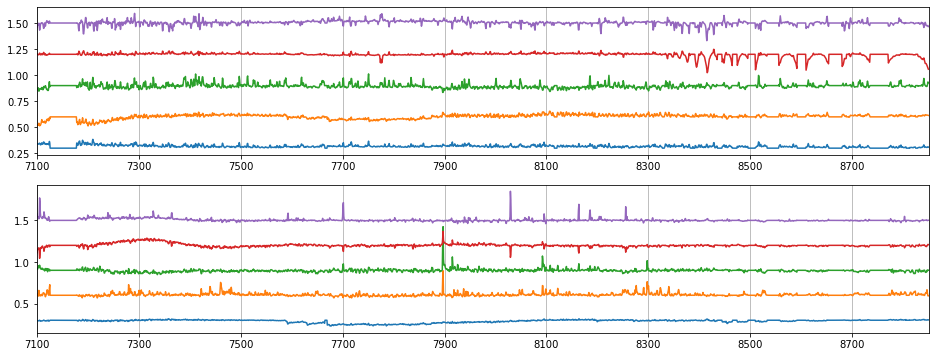

In [25]:
nNLv, nNSv = ds.eval_pcp(NLv, NSv, isM=0)

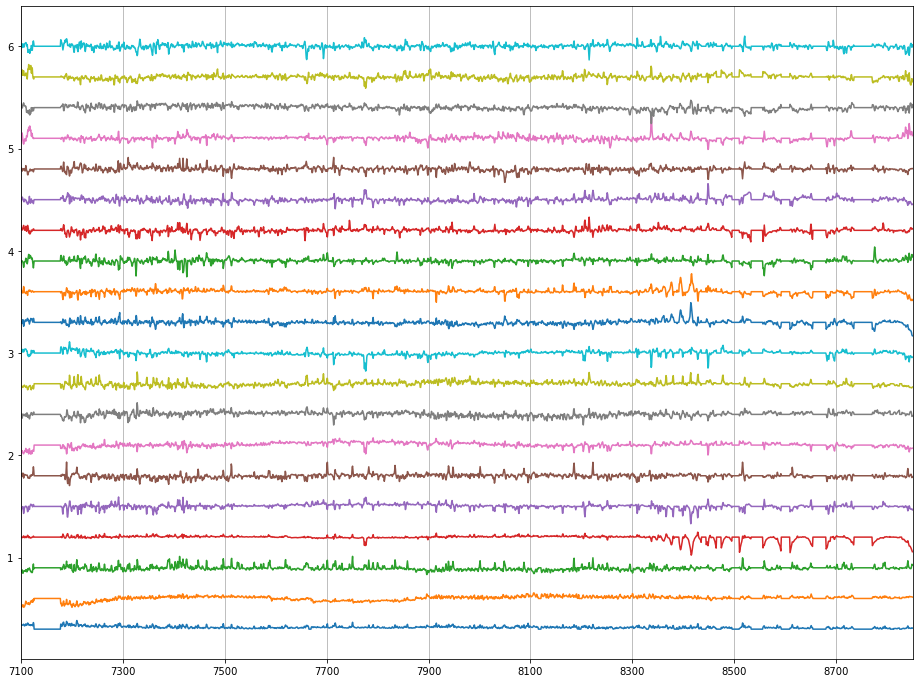

In [26]:
ds.plot_V(nNLv, top=20)

In [27]:
ds.pcp_transform(MLv, MSv, NLv, NSv, top=20)

In [28]:
PATH="/scratch/ceph/swei20/data/dnn/ALL/bosz_pcp_rbf10k.h5"

In [29]:
ds.pcp_np(save=1, PATH=PATH)

/scratch/ceph/swei20/data/dnn/ALL/bosz_pcp_rbf10k.h5


# Get informative lines

In [30]:
ds.prepare_lines()

In [35]:
ds.Cdx={}
ds.CdxAll = None

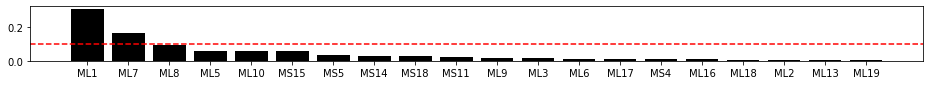

In [36]:
ds.get_X_cluster(X="M")

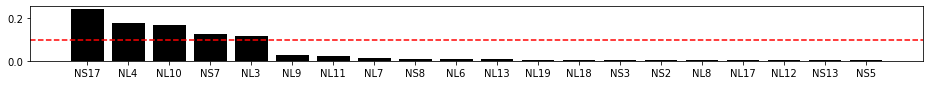

In [37]:
ds.get_X_cluster(X="N")

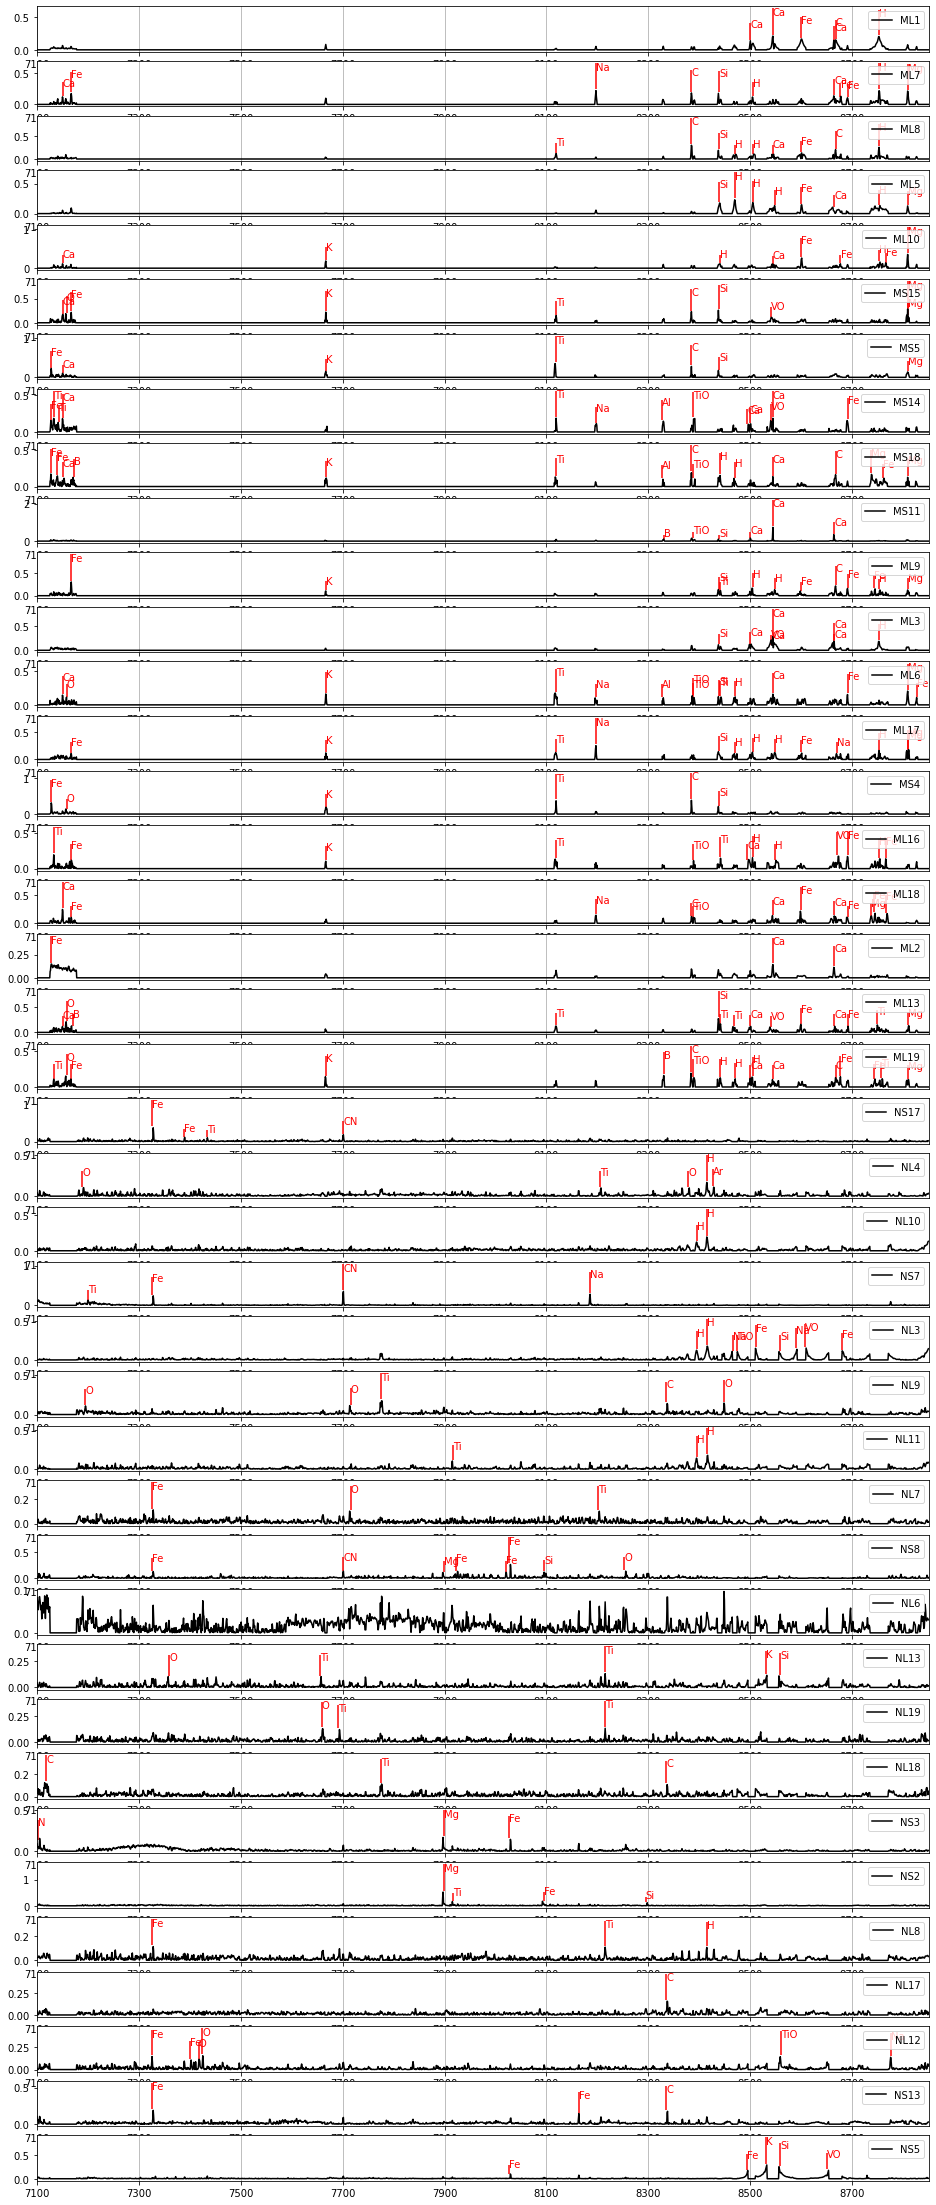

In [39]:
ds.plot_XdxAll(top=20, rfr=0)

In [63]:
ds.CdxAll.shape

(40,)

In [ ]:
ds.p

In [41]:
nFluxC = ds.npcpFlux[:, ds.CdxAll]

In [42]:
FluxC = ds.pcpFlux[:, ds.CdxAll]

In [44]:
FluxC.shape

(50000, 40)

In [45]:
from cuml import UMAP

In [46]:
umap_dim = 5
u = UMAP(n_neighbors=500, n_components=umap_dim)

In [47]:
uu = u.fit_transform(FluxC)

In [48]:
nuu = cp.asnumpy(uu)

In [49]:
dfumap = pd.DataFrame(data=nuu, columns = [f"u{i}" for i in range(umap_dim)])

In [50]:
# lbln = [RRs[int(lbls[i])] for i in range(len(lbls))]

In [51]:
dfumap["lbl"]=lbln

In [52]:
dfumap["lbl"].unique()

array(['M31G', 'MWW', 'MWC', 'BHB', 'RHB'], dtype=object)

In [54]:
import seaborn as sns

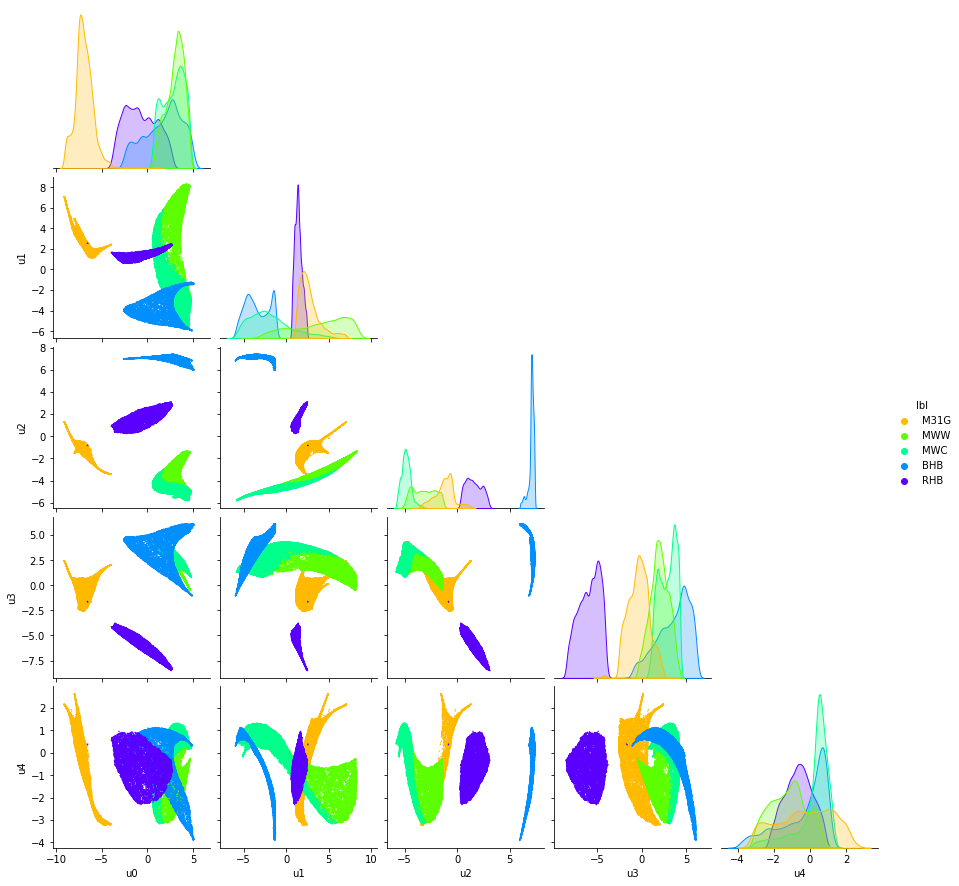

In [55]:
sns.pairplot(
    dfumap,
    x_vars = [f"u{i}" for i in range(umap_dim)],
    y_vars = [f"u{i}" for i in range(umap_dim)],
    hue = "lbl",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

<AxesSubplot:xlabel='u0', ylabel='u2'>

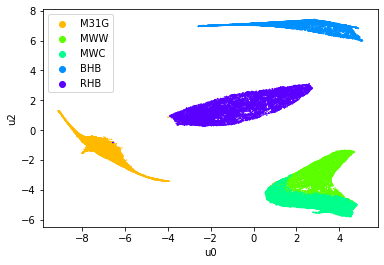

In [61]:
sns.scatterplot(data=dfumap, x="u0", y="u2",marker="o", s=2, edgecolor="none", hue=lbln, palette="gist_rainbow")

## Outliers live on the boundary of 2 regions

(-2.0, 0.0)

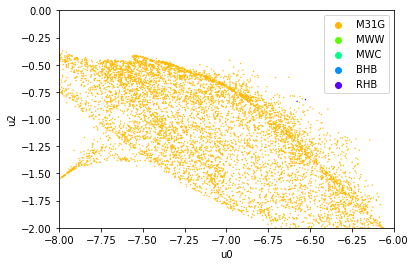

In [75]:
sns.scatterplot(data=dfumap, x="u0", y="u2",marker="o", s=2, edgecolor="none", hue=lbln, palette="gist_rainbow")
plt.xlim(-8,-6)
plt.ylim(-2,0)

In [72]:
idxx = dfumap[(dfumap["lbl"] =="RHB")&(dfumap["u0"]<-6)].index

In [73]:
ds.dfpara.iloc[idxx]

,F,T,L,C,O
42478,-0.147740,5000.492676,2.000214,0.330016,0.067313
49150,-0.086828,5069.869957,2.079780,0.441677,0.104948


- "M": **[[-2.5, 0.0], [3500, 5000], [0.0, 2.0],**
- "W": [[-2.0, 0.0], [5500, 7500], [3.5, 5.0],
- "C": [[-2.0, 0.0], [4500, 6000], [4.0, 5.0],
- "B": [[-2.5,-1.5], [7000, 9500], [2.0, 3.0]
- "R": **[[-1.0, 0.0], [5000, 6500], [2.0, 3.0]**
- "G": [[-2.5,-1.0], [3500, 5500], [0.0, 3.5]

In [68]:
pvals

array([[-2.18132136e+00,  4.67245511e+03,  1.01999652e+00,
         4.93654344e-01, -1.56585228e-01],
       [-1.04857990e+00,  3.63958873e+03,  1.04826429e+00,
        -4.35279280e-01,  2.47179627e-01],
       [-8.94329601e-01,  4.15524053e+03,  1.06713147e+00,
        -3.27899767e-01, -1.68533020e-01],
       ...,
       [-3.37862595e-01,  5.37974167e+03,  2.37650291e+00,
        -2.64019108e-01,  1.03131994e-01],
       [-3.31924374e-03,  6.34062209e+03,  2.97639103e+00,
         2.59450133e-01, -6.05913340e-02],
       [-7.05458665e-01,  5.24835580e+03,  2.96166457e+00,
        -6.51573554e-01,  4.55400262e-01]])

In [62]:
for i in range(cutoff*2):
    ds.dfpara[f"C{i}"] = nFluxC[:, i]

NameError: name 'cutoff' is not defined

In [ ]:
sns.pairplot(
    ds.dfpara,
    x_vars = [f"C{i}" for i in range(cutoff)],
    y_vars = [f"C{i}" for i in range(cutoff)],
    hue = "T",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

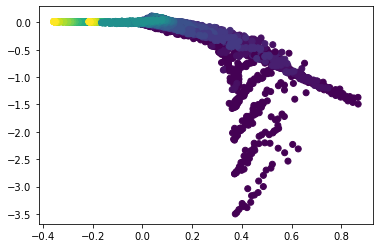

In [290]:
plt.scatter(nFluxC[:,0], nFluxC[:,cutoff + 0], c=ds.dfpara["T"].values)

In [ ]:
ds.dfpara

In [260]:
ds.dfpara

,F,T,L,C,O
0,-2.5,3500.0,0.0,-0.50,-0.25
1,-2.5,3500.0,0.0,-0.50,0.00
2,-2.5,3500.0,0.0,-0.50,0.25
3,-2.5,3500.0,0.0,-0.50,0.50
4,-2.5,3500.0,0.0,-0.25,-0.25
...,...,...,...,...,...
23344,0.0,6500.0,3.0,0.25,0.50
23345,0.0,6500.0,3.0,0.50,-0.25
23346,0.0,6500.0,3.0,0.50,0.00
23347,0.0,6500.0,3.0,0.50,0.25


<AxesSubplot:xlabel='u0', ylabel='u2'>

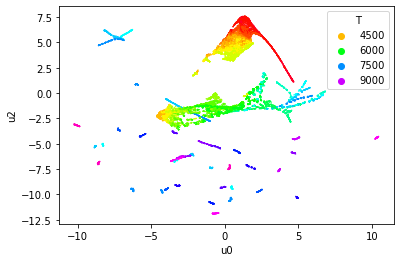

In [262]:
sns.scatterplot(data=dfumap, x="u0", y="u2", marker="o", s=2, edgecolor="none", hue=ds.dfpara["T"], palette="gist_rainbow")

In [ ]:
for i in range(umap_dim):
    df[f"u{i}"] = uu[:,i]

In [157]:
ds.Cs

{'M': array([35,  5, 25,  7, 13,  2, 38, 10, 30,  8, 15, 26, 24,  6,  9, 19, 28,
        16, 22, 17, 37, 32, 14,  3,  4, 11, 18, 27, 12, 31,  1, 39, 29,  0,
        20, 23, 21, 36, 33, 34]),
 'N': array([32, 27, 10, 39,  4, 11,  5, 38, 26,  3,  9,  8, 13, 12,  6, 17, 28,
        35, 15,  7, 14, 19, 36, 18, 16, 22, 34, 25, 24, 23,  1, 30, 31, 20,
         2, 29, 33, 37, 21,  0])}

In [ ]:
ds.get_all_Xrf(top=20, plot=1, X="M")

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=16, random_state=0, )

In [ ]:
rf.fit(, lbls)

In [16]:
np.hstack(lbls)

array([0., 0., 0., ..., 4., 4., 4.])

In [ ]:
flux.shape

In [11]:
p.nFlux

{'M': array([[-0.01792928, -0.00735136, -0.00585691, ..., -0.0013398 ,
         -0.00359439, -0.0026757 ],
        [-0.02216401, -0.01128094, -0.00974728, ..., -0.00129216,
         -0.00345479, -0.00254114],
        [-0.03249974, -0.02100932, -0.01949547, ..., -0.00094759,
         -0.00297128, -0.00211783],
        ...,
        [-0.03923602, -0.04686061, -0.05174412, ..., -0.03955266,
         -0.06657242, -0.04452206],
        [-0.0305062 , -0.03429768, -0.04188372, ..., -0.03378448,
         -0.06678738, -0.04612511],
        [-0.02268515, -0.02329823, -0.03281169, ..., -0.02824525,
         -0.066059  , -0.04689079]]),
 'W': array([[-0.00019615, -0.00019156, -0.00025279, ..., -0.00092497,
         -0.00167913, -0.00150203],
        [-0.00019154, -0.00018663, -0.00024746, ..., -0.00090038,
         -0.00174657, -0.0014763 ],
        [-0.00022118, -0.00015025, -0.00021058, ..., -0.00090116,
         -0.00174626, -0.00147616],
        ...,
        [-0.00175696, -0.0043516 , -0.018581

In [43]:
p.prepare_svd()

100%|██████████| 6/6 [00:47<00:00,  7.88s/it]


In [44]:
SPATH = f"/scratch/ceph/swei20/data/dnn/pc/bosz_{p.W[3]}_R{p.W[2]}.h5"

In [45]:
p.save_PCA(SPATH)

In [31]:
p.pcs["M"].shape

(7689, 200)

In [34]:
p.dfpara

,F,T,L,C,O
0,-2.5,3500.0,0.0,-0.50,-0.25
1,-2.5,3500.0,0.0,-0.50,0.00
2,-2.5,3500.0,0.0,-0.50,0.25
3,-2.5,3500.0,0.0,-0.50,0.50
4,-2.5,3500.0,0.0,-0.25,-0.25
...,...,...,...,...,...
51607,-1.0,5500.0,3.5,0.25,0.50
51608,-1.0,5500.0,3.5,0.50,-0.25
51609,-1.0,5500.0,3.5,0.50,0.00
51610,-1.0,5500.0,3.5,0.50,0.25


# Blue Arm

In [6]:
from lv.base.basePCA import PCA

In [7]:
p=PCA()
p.W = p.Ws["Blue"]

In [8]:
PATH = f"/scratch/ceph/szalay/swei20/AE/norm_flux_{p.W[3]}_R{p.W[2]}.h5"

with h5py.File(PATH, 'r') as f:
    flux0 = f['flux'][()]
    wave0 = f['wave'][()]
    para0 = f['para'][()]

In [9]:
p.prepare_data(flux0, wave0, para0)

# M flux: 7689, wave None: (5368,) 
# W flux: 6480, wave None: (5368,) 
# C flux: 3780, wave None: (5368,) 
# B flux: 3300, wave None: (5368,) 
# R flux: 2100, wave None: (5368,) 
# G flux: 9972, wave None: (5368,) 


In [11]:
p.prepare_svd()

100%|██████████| 6/6 [00:45<00:00,  7.52s/it]


In [12]:
SPATH = f"/scratch/ceph/swei20/data/dnn/pc/bosz_{p.W[3]}_R{p.W[2]}.h5"

In [13]:
p.save_PCA(SPATH)